### Fast fourier transformation ###

poging tot fast fourier transformatie 

**general Steps:**

1. loading file --> file of 12 reps (1 set) with 4 columns 
> - time (1500 Hz opgenomen)
> - 3 spieren met 3 verschillende meet punten vastus lateralis, rectus femoris & vastus medialis (voor nu wordt enkel VL gebruikt)
> - nog wa preproccessing 

2. threshold zetten alles boven de threshold is waneer ne rep bezig is onder de threshold is waneer da ni bezig is.
3. reps worden eruit geknipt en achter elkaar geplakt.
4. butterworth filter om onrealistische frequenties uit te halen  
5. fast fourier transformatie op los laten (ik krijg daar imaginaire nummers van terug: **paniek**)
6. median frequency eruit halen (khad eerst gewoon np.median(Zxx) maar toen gaf chatGPT da deel bij stap 6 wat ik  maar half begrijp )
7. OLS van median frequencys (opt moment gewoon efkes rap met een grafiek ma das nimeer het probleem) 

In [110]:
import pandas as pd
import numpy as np

from scipy.signal import butter, filtfilt, stft

import matplotlib.pyplot as plt
import seaborn as sns

In [111]:
file_path = "hyp 8 sets set 8 LE.txt"
fs = 1500

step 1

In [112]:
df = pd.read_csv(file_path, delimiter='\t', skiprows=4)
df.rename(columns={
                'Time,s': 'time',
                'RT VLO,uV' : 'vl',
                'RT RECTUS FEM.,uV' : 'rf',
                'RT VMO,uV' : 'vm'
                
                }, inplace=True)
        
        
df['time'] = pd.to_datetime(df['time'], unit='s')
df['rep'] = None
df = df.drop([column for column in df.columns if column.startswith('Mark')], axis=1)

step 2

In [113]:
def rolling_avg(df, window_size='200ms', columns=['vl', 'rf', 'vm']):
    window_size_int = int(pd.Timedelta(window_size).total_seconds() * 1000)
    for column in columns:
        df[f'{column}_abs'] = df[column].abs()
        df[f'Rolling_average_{column}'] = df[f'{column}_abs'].rolling(window=window_size_int, min_periods=1, center=True).mean()
    return df

step 3

<Axes: xlabel='None', ylabel='vl_abs'>

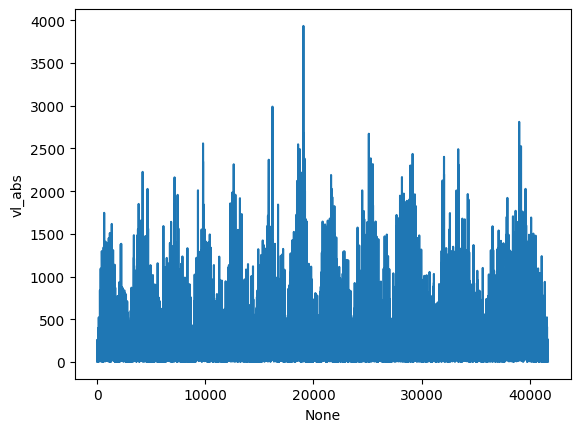

In [114]:
df = rolling_avg(df, window_size='200ms')
df = df[df['Rolling_average_vl'] > 90]
df = df.reset_index(drop=True)

sns.lineplot(data=df, x=df.index, y='vl_abs')

In [115]:
def _butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = _butter_bandpass(lowcut, highcut, fs, order=order)
    filterd_data = filtfilt(b, a, data)
    
    #emg_rectified = abs(filterd_data)
    emg_envelope = filterd_data
    return emg_envelope

step 4

In [116]:
df['filterd_vl'] = butter_bandpass_filter(df['vl'], 5, 450, fs)

<Axes: xlabel='None', ylabel='filterd_vl'>

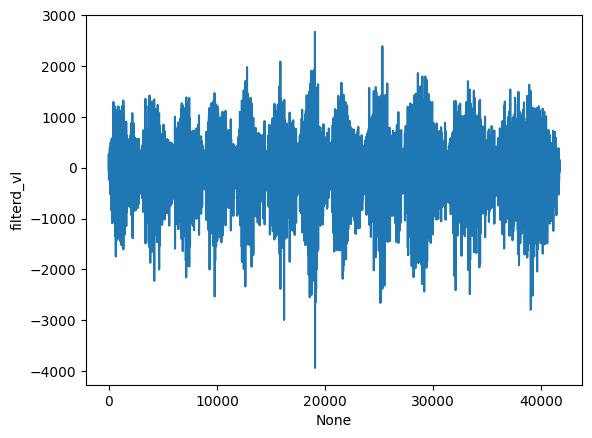

In [117]:
sns.lineplot(df, x=df.index, y='filterd_vl')

step 5

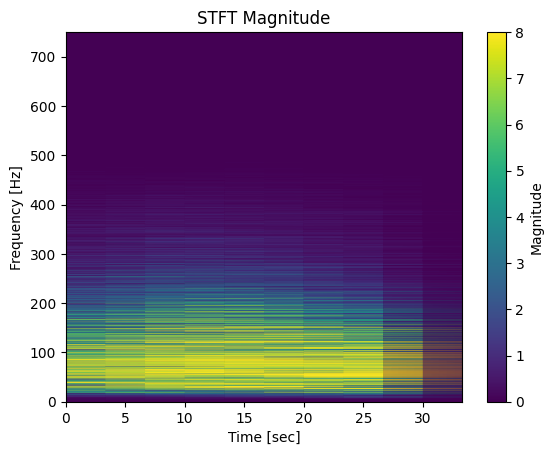

In [118]:
f, t, Zxx = stft(df['filterd_vl'], fs, nperseg=20000, noverlap=None)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=8, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
cbar = plt.colorbar(label='Magnitude')
plt.show()

step 6

In [119]:

power_spectrum = np.abs(Zxx)**2
median_frequencies = np.zeros(len(t))

for i, time_frame in enumerate(power_spectrum.T):  # Transpose power_spectrum to iterate over time frames
    # Compute cumulative distribution function (CDF)
    cum_sum = np.cumsum(time_frame)
    cum_sum /= cum_sum[-1]  # Normalize to [0, 1]

    # Find index corresponding to median value of CDF
    median_index = np.argmax(cum_sum >= 0.5)

    # Retrieve median frequency from frequency array
    median_frequency = f[median_index]

    # Store median frequency for this time frame
    median_frequencies[i] = median_frequency
    
    

step 7

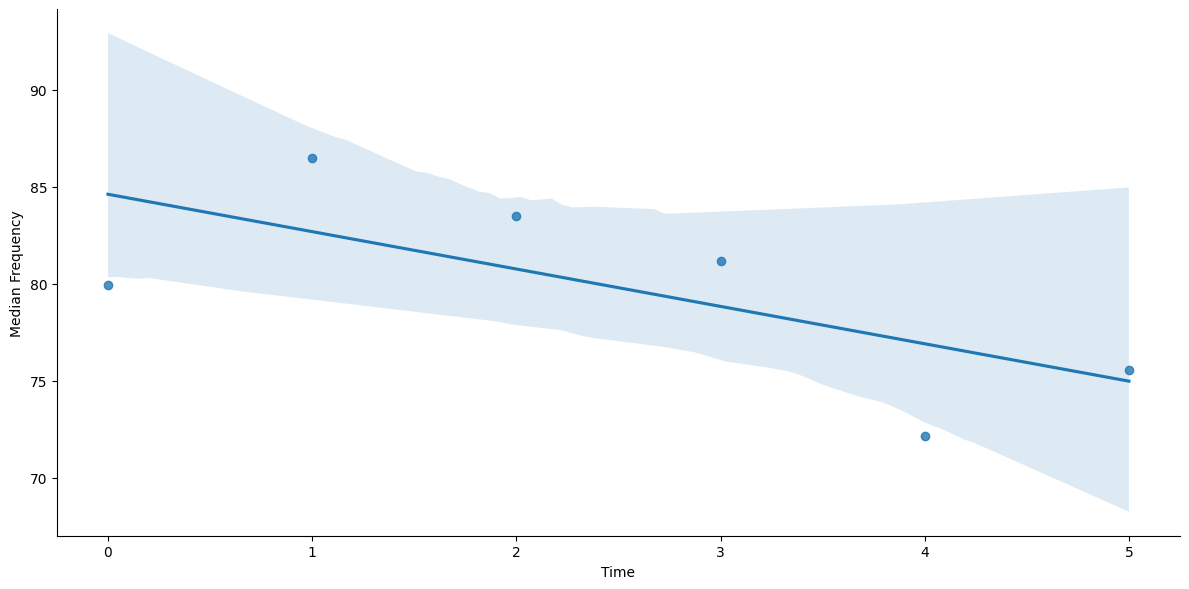

In [120]:
# Create a DataFrame with time as x and median frequencies as y
data = {'Time': range(len(median_frequencies)), 'Median Frequency': median_frequencies}
df = pd.DataFrame(data)

# Plot using lmplot
sns.lmplot(x='Time', y='Median Frequency', data=df, height=6, aspect=2)